In [15]:
from localgraphclustering import *

import time
import numpy as np

# Import the graph_tool module for visualization.
from graph_tool.all import * 

# Import matplotlib 
import matplotlib.pyplot as plt

# Just a useful function.
def diff(a, b):
        b = set(b)
        return np.asarray([aa for aa in a if aa not in b], dtype = 'int64')

# Load graph

In [16]:
# Read graph. This also supports gml and graphml format.
g = graph_class_local.GraphLocal('./datasets/senate.edgelist','edgelist',' ')

# Global graph partitioning

In [17]:
# Create an object for global spectral partitioning
sp = spectral_partitioning.Spectral_partitioning()

# Call the global spectral partitioning algorithm.
output_sp = sp.produce([g])

# Only one input graph is given, i.e., [g]. 
# Extract the array from position 0 and store it.
eig2 = output_sp[0]

## Compute layout for visualization

In [18]:
# Add data to graphtool.
g_gtool = Graph(directed=False)
m = g._num_edges
for i in range(m):
    g_gtool.add_edge(g.edges[0][i], g.edges[1][i], add_missing=True)  
    
remove_self_loops(g_gtool)

#prop = g.new_vertex_property("vector<double>")
#for i in range(n):
#    prop[i] = [1 + i,1 + i]

# Compute a layout for the graph.
pos = sfdp_layout(g_gtool, gamma=10.0, mu=10.0, mu_p=10.0, verbose = False)  

## Visualization of global eigenvector on Senate

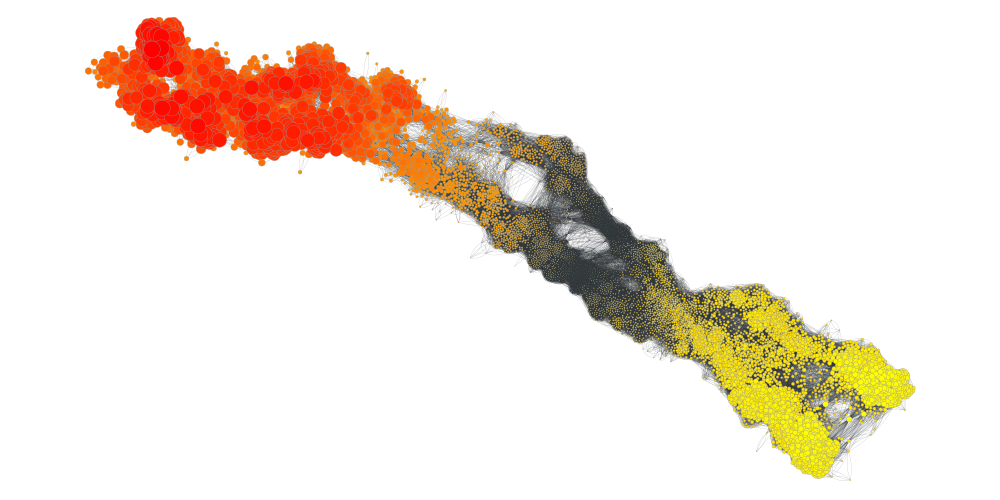

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12b0b55f8, at 0x10c2d1cc0>

In [19]:
# Plot solutions for global eigenvector
node_weights = g_gtool.new_vertex_property("double",eig2)
node_size = g_gtool.new_vertex_property("double",np.abs(eig2)*500)

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, vertex_fill_color=node_weights, vorder=node_size,
           edge_pen_width=0.1,
           vcmap=c_map)

# For exaplanation of the senate data please refer to
# K. Fountoulakis, D. Gleich and M. Mahoney, An optimization approach to locally-biased graph algorithms,
# Proceedings of the IEEE 105 (2), 256-272.

## Obtain the partition using the global eigenvector

In [20]:
# Create an object for the sweep cut rounding procedure.
sc = sweepCut_general.SweepCut_general()

# Round the eigenvector
output_sc = sc.produce([g],p=eig2)

# Extract the partition for g and store it.
eig2_rounded = output_sc[0][0]

## Visualize the partition

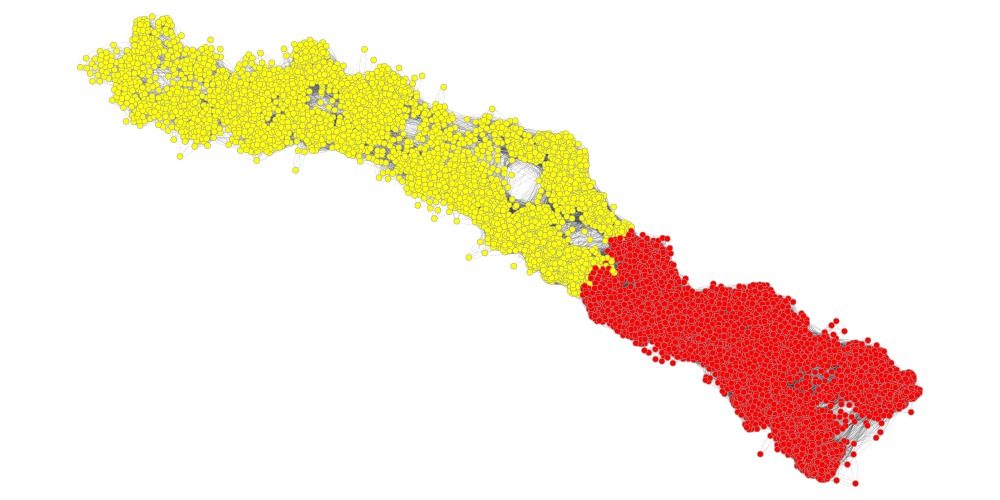

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12b0b55f8, at 0x10c2d1cc0>

In [21]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 0.00001

eig2_rounded_c = diff(range(g._num_vertices), eig2_rounded)

temp[eig2_rounded] = 6
temp[eig2_rounded_c] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in eig2_rounded:
    temp[i] = "yellow"
for i in eig2_rounded_c:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1)

## Global partitioning of John Hopkins

In [8]:
# Read John Hopkins graph.
g = graph_class_local.GraphLocal('./datasets/JohnsHopkins.edgelist','edgelist','\t')

# Create an object for global spectral partitioning
sp = spectral_partitioning.Spectral_partitioning()

# Call the global spectral partitioning algorithm.
output_sp = sp.produce([g])

# Only one input graph is given, i.e., [g]. 
# Extract the array from position 0 and store it.
eig2 = output_sp[0]

# Create an object for the sweep cut rounding procedure.
sc = sweepCut_general.SweepCut_general()

# Round the eigenvector
output_sc = sc.produce([g],p=eig2)

# Extract the partition for g and store it.
eig2_rounded = output_sc[0][0]

## Visualize global graph partitioning of John Hopkins

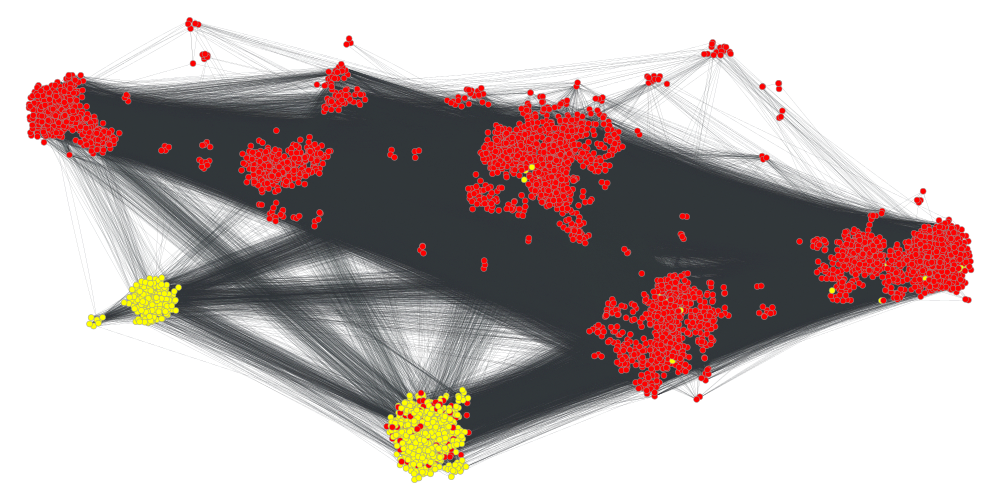

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12b0b5908, at 0x12b0d0a58>

In [9]:
# Add data to graphtool.
g_gtool = Graph(directed=False)
m = g._num_edges
for i in range(m):
    g_gtool.add_edge(g.edges[0][i], g.edges[1][i], add_missing=True)  
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 0.00001

eig2_rounded_c = diff(range(g._num_vertices), eig2_rounded)

temp[eig2_rounded] = 6
temp[eig2_rounded_c] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in eig2_rounded:
    temp[i] = "yellow"
for i in eig2_rounded_c:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1)

## Localized vector using l1-regularized PageRank

In [10]:
# Read John Hopkins graph; a better graph than senate to demonstrate local graph clustering properties.
g = graph_class_local.GraphLocal('./datasets/JohnsHopkins.edgelist','edgelist','\t')

# Create an object for an accelerated L1-regularized PageRank solver.
l1reg_fast = l1_regularized_PageRank_fast.L1_regularized_PageRank_fast()

# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
reference_node = 2767
output_l1reg_fast = l1reg_fast.produce([g],[reference_node],rho=5.0e-5)

# Only one input graph is given, i.e., [g]. 
# Extract the array from position 0 and store it.
l1_reg_vector = output_l1reg_fast[0]

## Load layout for John Hopkins graph

In [11]:
# Add data to graphtool.
g_gtool = Graph(directed=False)
m = g._num_edges
for i in range(m):
    g_gtool.add_edge(g.edges[0][i], g.edges[1][i], add_missing=True)  
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]

## Visualize localized vector for John Hopkins and reference node 2767

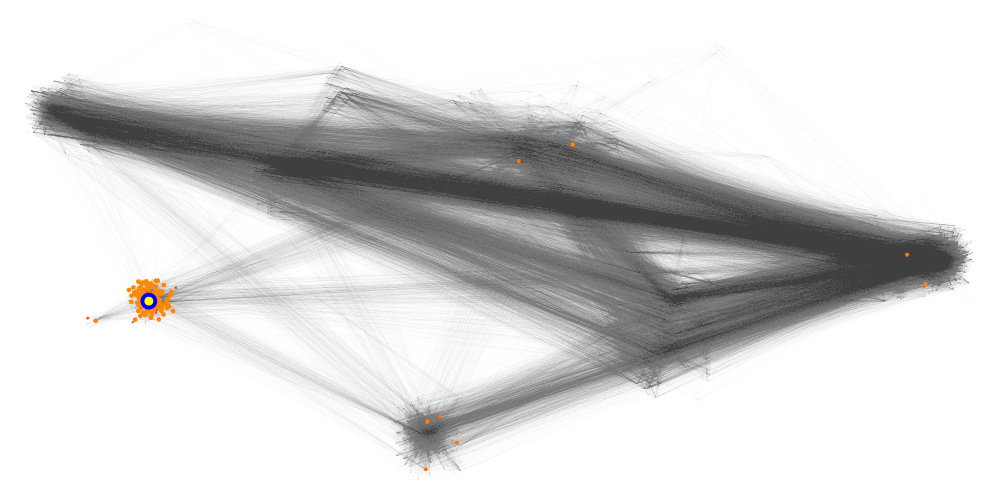

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12b0ae5f8, at 0x124caaef0>

In [12]:
# Some pre-processing to make visualization better.
temp = np.copy(l1_reg_vector)
nnz_temp = temp.nonzero()
nnz_temp = nnz_temp[0]
temp[nnz_temp] = -np.log(temp[nnz_temp])
temp[nnz_temp] = 100/temp[nnz_temp]
temp = temp + 0.0001
max_all = max(temp)
temp[reference_node] = max_all/2.6
temp = temp/np.linalg.norm(temp, 2)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[reference_node] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

node_weights = g_gtool.new_vertex_property("double",temp)
node_size = g_gtool.new_vertex_property("double",np.abs(temp)*50)

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, vertex_fill_color=node_weights, vorder=node_size,
           vertex_halo=node_halo,
           vertex_halo_size = 1.9,
           vertex_halo_color = "blue",
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Obtain the partition using the localized vector from l1-regularized PageRank

In [13]:
# Create an object for a C++ version of the sweep cut rounding procedure.
sc_fast = sweepCut_fast.SweepCut_fast()

# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sc_fast.produce([g],p=l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded = output_sc_fast[0][0]

## Visualize local partitioning of John Hopkins

In [ ]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 0.00001

temp[l1_reg_vector_rounded] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in l1_reg_vector_rounded:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05])

## Visualization of cluster boundary

In [4]:
from heapq import heappush, heappop
import sys,itertools

class PQ(object):
    def __init__(self):
        self.pq = []
        self.entry_finder = {}
        self.REMOVED = '<removed-task>'
        self.counter = itertools.count()
    def add_task(self,task, priority=0):
        'Add a new task or update the priority of an existing task'
        if task in self.entry_finder:
            self.remove_task(task)
        count = next(self.counter)
        entry = [priority, count, task]
        self.entry_finder[task] = entry
        heappush(self.pq, entry)

    def remove_task(self,task):
        'Mark an existing task as REMOVED.  Raise KeyError if not found.'
        entry = self.entry_finder.pop(task)
        entry[-1] = self.REMOVED

    def pop_task(self):
        'Remove and return the lowest priority task. Raise KeyError if empty.'
        while self.pq:
            priority, count, task = heappop(self.pq)
            if task is not self.REMOVED:
                del self.entry_finder[task]
                return task,priority
        raise KeyError('pop from an empty priority queue')

def boundary_visualization(g,s):
    ai = g.adjacency_matrix.indptr
    aj = g.adjacency_matrix.indices
    a = g.adjacency_matrix.data
    B = set()
    S = set(s)
    # Find the boudary set of the target cluster
    for i in S:
        for j in range(ai[i],ai[i+1]):
            if aj[j] not in S:
                B.add(aj[j])
    b = list(B)
    data = []
    mapping = {b[i]:i for i in range(len(b))}
    g_gtool = Graph(directed=False)
    elen = g_gtool.new_edge_property("float")
    g_gtool.add_vertex(len(b))
    maxlen = 0
    for i in range(len(b)):
        u = b[i]
        length = shortest_path(ai,aj,a,u,b,S)
        maxlen = max([maxlen]+list(length.values()))
        data.append(length)
    for i in range(len(b)):
        u = b[i]
        for j in range(i+1,len(b)):
            v = b[j]
            e = g_gtool.add_edge(g_gtool.vertex(mapping[u]),g_gtool.vertex(mapping[v]))
            length = data[i]
            elen[e] = length[v] if v in length else maxlen
    # Visualize the boudary set such that the distance between each pair of nodes is preserved
    pos = graphviz_draw(g_gtool,layout="neato",elen=elen)
    new_g = Graph()
    new_g.add_vertex(len(b))
    new_pos = new_g.new_vertex_property("vector<float>")
    for i in range(len(b)):
        new_pos[new_g.vertex(i)] = pos[g_gtool.vertex(i)]
    graph_draw(new_g,pos=new_pos,vertex_size=5,inline=True)
    return new_pos,new_g

# find the shortest path between each pair of boudary nodes
def shortest_path(ai,aj,a,src,b,S):
    n = len(ai) - 1
    u = src
    visited = set()
    visited.add(u)
    count = 0
    Boundary = {}
    B = set(b)
    pq = PQ()
    dist = 0
    if u in B:
        count += 1
        Boundary[u] = dist
    while count < len(b):
        for j in range(ai[u],ai[u+1]):
            v = aj[j]
            if v not in S:
                if (v not in pq.entry_finder) or (dist+a[j] < pq.entry_finder[v][0]):
                    pq.add_task(v,dist+a[j])
        try:
            u,dist = pq.pop_task()
            while u in visited:
                u,dist = pq.pop_task()
            visited.add(u)
            if u in B:
                count += 1
                Boundary[u] = dist
        except:
            break
    return Boundary

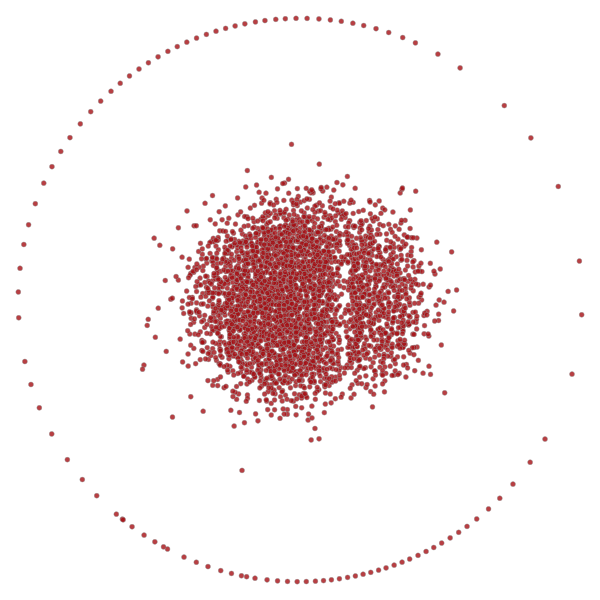

2059.2362837791443


In [5]:
import time
# Create an object for the l1-regularized PageRank algorithm + Rounding (this method uses a fast C++ implementation).
l1reg_clustering = l1_regularized_PageRank_Clustering.L1_regularized_PageRank_Clustering()
g = graph_class_local.GraphLocal('./datasets/JohnsHopkins.edgelist','edgelist','\t')
# Find a cluster using approximate PageRank.
output_l1reg_clustering = l1reg_clustering.produce([g],[3215])
t1 = time.time()
pos,G = boundary_visualization(g,output_l1reg_clustering[0])
t2 = time.time()
print(t2-t1)